In [1]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
from tqdm.notebook import tqdm
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

In [20]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Load CIFAR10

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 100

trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


#### Get Model

In [4]:
from torchvision.models import resnet50, ResNet50_Weights, resnet18

In [5]:
model = resnet50()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Get Optimizer

In [6]:
import torch.optim as optim
from torch import nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train

In [13]:
epochs = 50

acc_train = []
loss_train = []
acc_val = []
loss_val = []

for epoch in range(epochs):  # loop over the dataset multiple times

    with tqdm(total=len(trainloader)) as pbar_train:
    
        model.train()
        train_acc_collect = []
        train_loss_collect = []
        
        for i, data in enumerate(trainloader, 0):
            
            # get the inputs; data is a list of [inputs, labels]
            
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            # zero the parameter gradients
            
            optimizer.zero_grad()
    
            # forward + backward + optimize
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)  # get argmax of predictions
            accuracy = np.mean(list(predicted.eq(labels.data).cpu()))  # compute accuracy
            train_acc_collect.append(accuracy)
            train_loss_collect.append(loss.cpu().data.numpy())

            print('LOSS_TRAIN: ',loss.cpu().data.numpy(),'  ' ,'ACC_TRAIN: ',accuracy,end = '\r')
            
            pbar_train.update(1)
            pbar_train.set_description("Iterations")

        acc_train.append(np.mean(train_acc_collect))
        loss_train.append(np.mean(train_loss_collect))
    
    with tqdm(total=len(testloader)) as pbar_val:
        
        model.eval()
        vall_acc_collect = []
        vall_loss_collect = []
        
        for i, data in enumerate(testloader, 0):

            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)  # get argmax of predictions
            accuracy = np.mean(list(predicted.eq(labels.data).cpu()))  # compute accuracy
            vall_acc_collect.append(accuracy)
            vall_loss_collect.append(loss.cpu().data.numpy())

            print('LOSS_TRAIN: ',loss.cpu().data.numpy(),'  ' ,'ACC_TRAIN: ',accuracy,end = '\r')
            
            pbar_val.update(1)
            pbar_val.set_description("Iterations")

        acc_val.append(np.mean(vall_acc_collect))
        loss_val.append(np.mean(vall_loss_collect))

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
import matplotlib.pyplot as plt

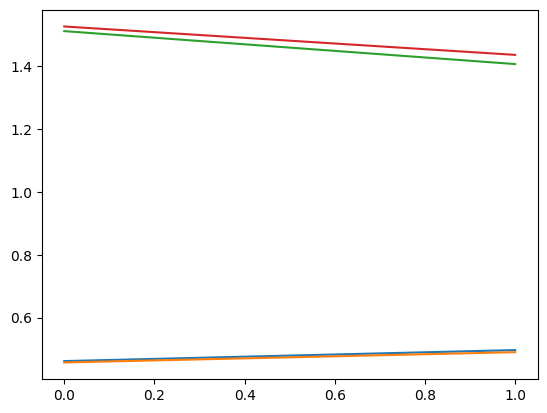

In [18]:
plt.plot(acc_train)
plt.plot(acc_val)
plt.plot(loss_train)
plt.plot(loss_val)

In [20]:
np.mean(_.cpu().numpy())

17.387886

In [19]:
acc_train

[0.4616, 0.49664]